# SHapley Additive exPlanations (SHAP) 

        SHAP is a game theoretic approach to explain the output of any machine learning model and the features significance.
        
<br>

In [36]:
# !pip install shap
import shap

location = 'datasets/'

import os, random, time, fsspec, gunzip, datetime, requests, copy, inspect, collections, itertools

import pandas as pd, pandas_datareader as pd_dr, re
import numpy as np, seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn, sklearn_pandas
from sklearn import *
import missingno as msno
import h5py, pickle, urllib

import scipy, scipy.stats as stats, random, math
from sklearn.pipeline import Pipeline
from math import sqrt
import joblib, re

import matplotlib, graphviz
import matplotlib.pyplot as plt
from matplotlib import *
plt.style.use('dark_background')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost; import xgboost as xgb

import hyperopt
import hyperopt as hopt

%matplotlib inline
%config Completer.use_jedi = False
%matplotlib inline

np.random.seed(1)

#### SHAP plots

In [37]:
health_df = pd.read_csv( location + 'healthcare-dataset-stroke-data.csv' )

health_df.drop( columns= 'id', inplace= True )
health_df = health_df.dropna()

health_df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


In [38]:
## One hot encoding udf

def OHE_func( df, categorical_col ):
    '''
    function that returns one=hot-encoded dataframe for the given categorical column list.
    Also removes the original column
    input:
    df = dataframe
    categorical_col = list of string of categorical columns to be one-hot encoded '''
    OHEncoder = sklearn.preprocessing.OneHotEncoder( sparse= False, drop= 'first', dtype= np.int8 )
    OHEncoded_np = OHEncoder.fit_transform( df[categorical_col] )
    OHEncoded_df = pd.DataFrame( OHEncoded_np, index= df.index,
                                 columns= OHEncoder.get_feature_names(input_features=categorical_col) )
    return(   df.drop( columns= categorical_col ).merge( OHEncoded_df, left_index= True, right_index= True )   )    

In [39]:
cat_col = [ 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status' ]

healthCat_df = OHE_func( df = health_df, categorical_col= cat_col ) 

# train test
xtrn,xtst, ytrn, ytst = sklearn.model_selection.train_test_split(  healthCat_df.drop( columns= 'stroke' ),
                                                                   healthCat_df[['stroke']], test_size= 30./100  )
print( ytrn[:2] );  xtrn.head(2)

      stroke
478        0
3798       0


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
478,66.0,0,0,87.24,22.5,0,0,1,0,0,0,0,1,1,0,0
3798,5.0,0,0,112.11,20.1,1,0,0,0,0,0,1,1,0,0,0


[20:02:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


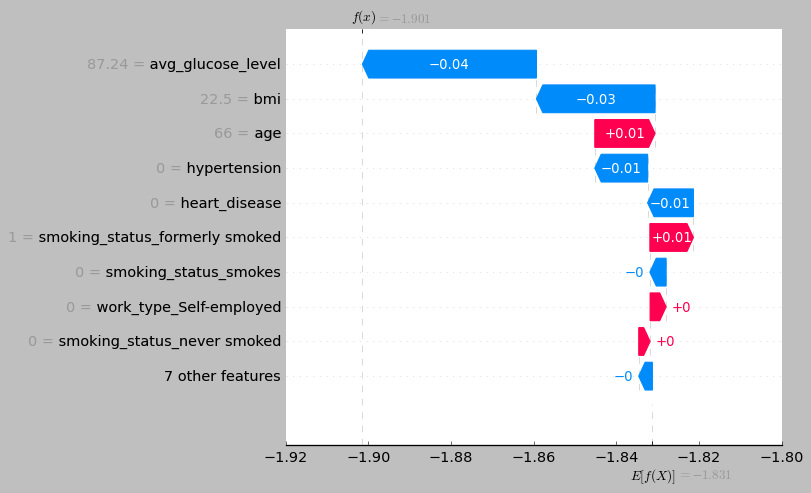

In [41]:
## Water fall plot using xgboost classifier
# boston_df, housePrice = shap.datasets.boston()
xgbReg_est = xgboost.XGBRFClassifier().fit( xtrn, ytrn )

# explain the model's predictions using SHAP
shapExplainer = shap.Explainer( model= xgbReg_est )
shapVal_np = shapExplainer( X= xtrn )

# visualize the first prediction's explanation
shap.plots.waterfall( shap_values= shapVal_np[0] )

<br>

### Beeswarm plot

The color represents the feature value (red high, blue low). This reveals for example that a high `Age` increases the chance of stroke, while `Married status` decreases the chance of Stroke.

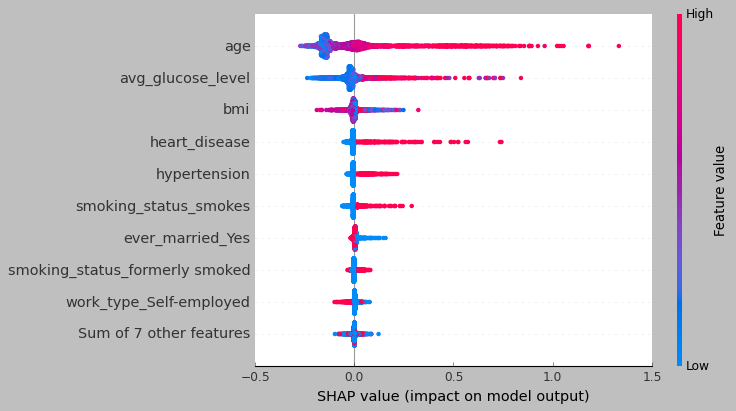

In [42]:
shap.plots.beeswarm( shap_values= shapVal_np  )

Plotting the mean absolute value of the SHAP values for each feature as a bar plot (it produces stacked bars for multi-class outputs)

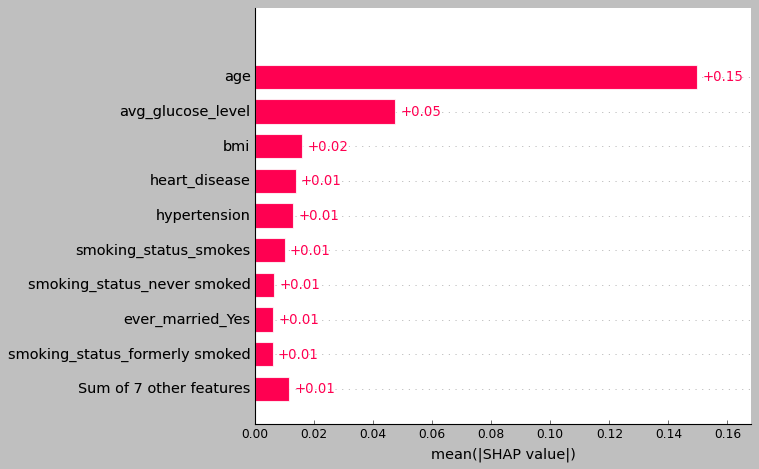

In [43]:
shap.plots.bar( shap_values= shapVal_np )

<br>

### other SHAP plots

In [44]:
## Random forest

randForest_est = sklearn.ensemble.RandomForestClassifier(  )
randForest_est.fit( xtrn, ytrn )

yhat = randForest_est.predict( xtst )

f1_score, accuracy_RF = sklearn.metrics.f1_score( ytst, yhat, average= 'macro' ), sklearn.metrics.accuracy_score( ytst, yhat )

print(  'F1 score --> {:0.3f} \t | \t  Accuracy --> {:0.3f}'.format(f1_score,accuracy_RF)  )

F1 score --> 0.489 	 | 	  Accuracy --> 0.955


#### `SHAP` internal variables

In [45]:
# create shap explainer
shapExplainer = shap.TreeExplainer( model= randForest_est )

# calc shapley vlaues for test data
start_idx, end_idx = 200,201
shapVal_np = shapExplainer.shap_values( X= xtst[start_idx:end_idx] )

print( len( shapVal_np ), shapVal_np[0].shape, '\n' );                 print( shapVal_np[0], '\n' )

2 (1, 16) 

[[ 2.11365896e-02  7.34960264e-03  2.05064388e-03  8.39880022e-04
  -4.02790769e-04 -5.63806339e-04  0.00000000e+00  5.12078676e-03
  -5.35726338e-06  6.79134985e-04 -2.40209121e-04  3.48686602e-03
   3.58484619e-04  1.12278606e-03 -3.17124728e-04  1.46833207e-03]] 



`Force plots` allows to observe how features contributed to the model’s prediction for a specific observation. 

The binary target was person had a Stroke ( = 1), or no they didn’t had ( = 0). In the plot below, the bold 0.02 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.
So this particular person was ultimately classified as will not have Stroke (0), because they were pushed higher by all the factors shown in Blue ( Avg Glucose level, no hypertension, no heart disease, etc. ).

In [46]:
## visualize local prediction

shap.initjs()

yhat = randForest_est.predict( xtst[start_idx:end_idx] )[0]
print( f'Random Forest Prediction --> {yhat}' )

shap.force_plot( base_value= shapExplainer.expected_value[1], shap_values= shapVal_np[1], features= xtst[start_idx:end_idx] )

Random Forest Prediction --> 0


If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (as done below)

In [47]:
## shap plot for all (or many) obvs

idx_upto = 50
# create shap explainer
shapExplainer = shap.TreeExplainer( model= randForest_est )

# calc shapley vlaues for test data
shapVal_np = shapExplainer.shap_values( X= xtst )

## visualize local prediction
# shap.initjs()
shap.plots.force(  base_value= shapExplainer.expected_value[1], shap_values= shapVal_np[1][:idx_upto] )

In [49]:
## shap plot for some (zooming in)
idx_upto = 7
shap.plots.force(  base_value= shapExplainer.expected_value[1], shap_values= shapVal_np[1][:idx_upto] )

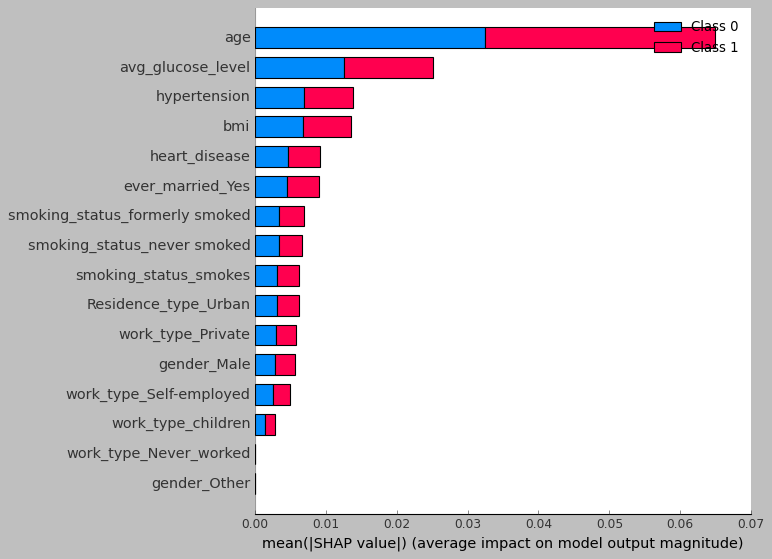

In [51]:
shap.summary_plot( shap_values= shapVal_np, features= xtst )

<br>

### SHAP Dependence Plots

A SHAP dependence plot show how the model output varies by feauture value.

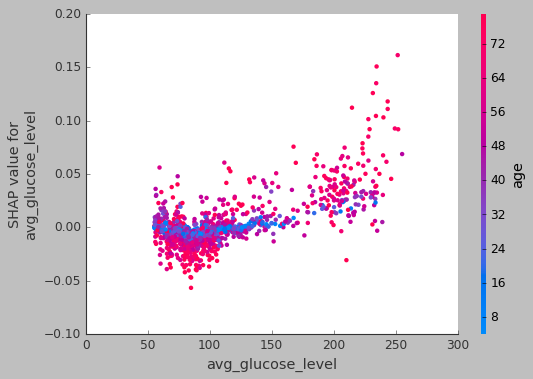

In [66]:
shap.dependence_plot( ind= 'avg_glucose_level', shap_values= shapVal_np[1],  # <-- index 1 is the stroke = yes case
                      features= xtst, show= False )

### SHAP Dependence Plots with Interaction effect

Plotting the `interaction effects` involving `age`. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above.

In [74]:
shap_interaction_values = shap.TreeExplainer( model= randForest_est ).shap_interaction_values( X= xtst )

In [86]:
xtst.head(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2648,52.0,0,0,87.26,40.1,1,0,1,0,0,0,0,0,0,0,1
3441,59.0,0,0,90.06,28.9,0,0,1,0,0,1,0,1,0,0,1


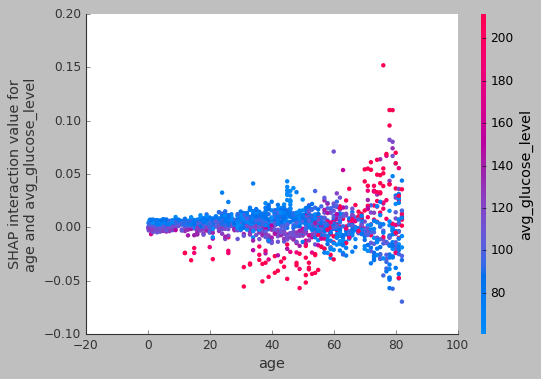

In [104]:
shap.dependence_plot(  ind= ( 'age', 'avg_glucose_level' ), shap_values= shap_interaction_values[1], features= xtst )

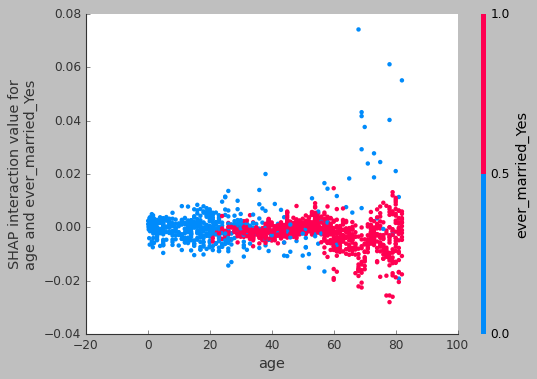

In [106]:
shap.dependence_plot(  ind= ( 'age', 'ever_married_Yes' ), shap_values= shap_interaction_values[1], features= xtst )